# Python Code - Data Driven approach for Poverty Anlysis and Prediction System

## Importing Libraries

In [274]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

## Load Dataset

In [275]:
train_data = pd.read_csv('train_labels.csv')
test_data = pd.read_csv('test_values.csv')
poverty_data = pd.read_csv('poverty_dataset.csv')

## Exploratory Data Analysis

In [276]:
# Display basic information about the datasets
print("Train dataset information:")
print(train_data.info())

print("\nTest dataset information:")
print(test_data.info())

print("\nPoverty dataset information:")
print(poverty_data.info())

# Summary statistics of the poverty dataset
print("\nSummary statistics of the Poverty dataset:")
print(poverty_data.describe())

Train dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   row_id               12600 non-null  int64  
 1   poverty_probability  12600 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 197.0 KB
None

Test dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8400 entries, 0 to 8399
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   row_id                                 8400 non-null   int64  
 1   country                                8400 non-null   object 
 2   is_urban                               8400 non-null   bool   
 3   age                                    8400 non-null   float64
 4   female                                 8400 non-null   bool  

In [277]:
# Merge the poverty probability from train_data into the poverty_dataset
merged_data = poverty_data.merge(train_data, on='row_id', how='left')

In [278]:
merged_data.shape

(12600, 60)

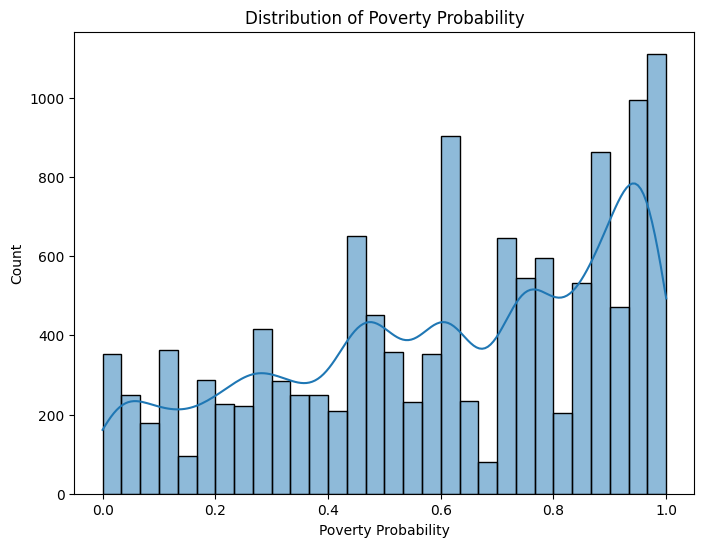

In [279]:
# Distribution of the target variable (poverty_probability) in the train dataset
plt.figure(figsize=(8, 6))
sns.histplot(train_data['poverty_probability'], bins=30, kde=True)
plt.title("Distribution of Poverty Probability")
plt.xlabel("Poverty Probability")
plt.ylabel("Count")
plt.show()

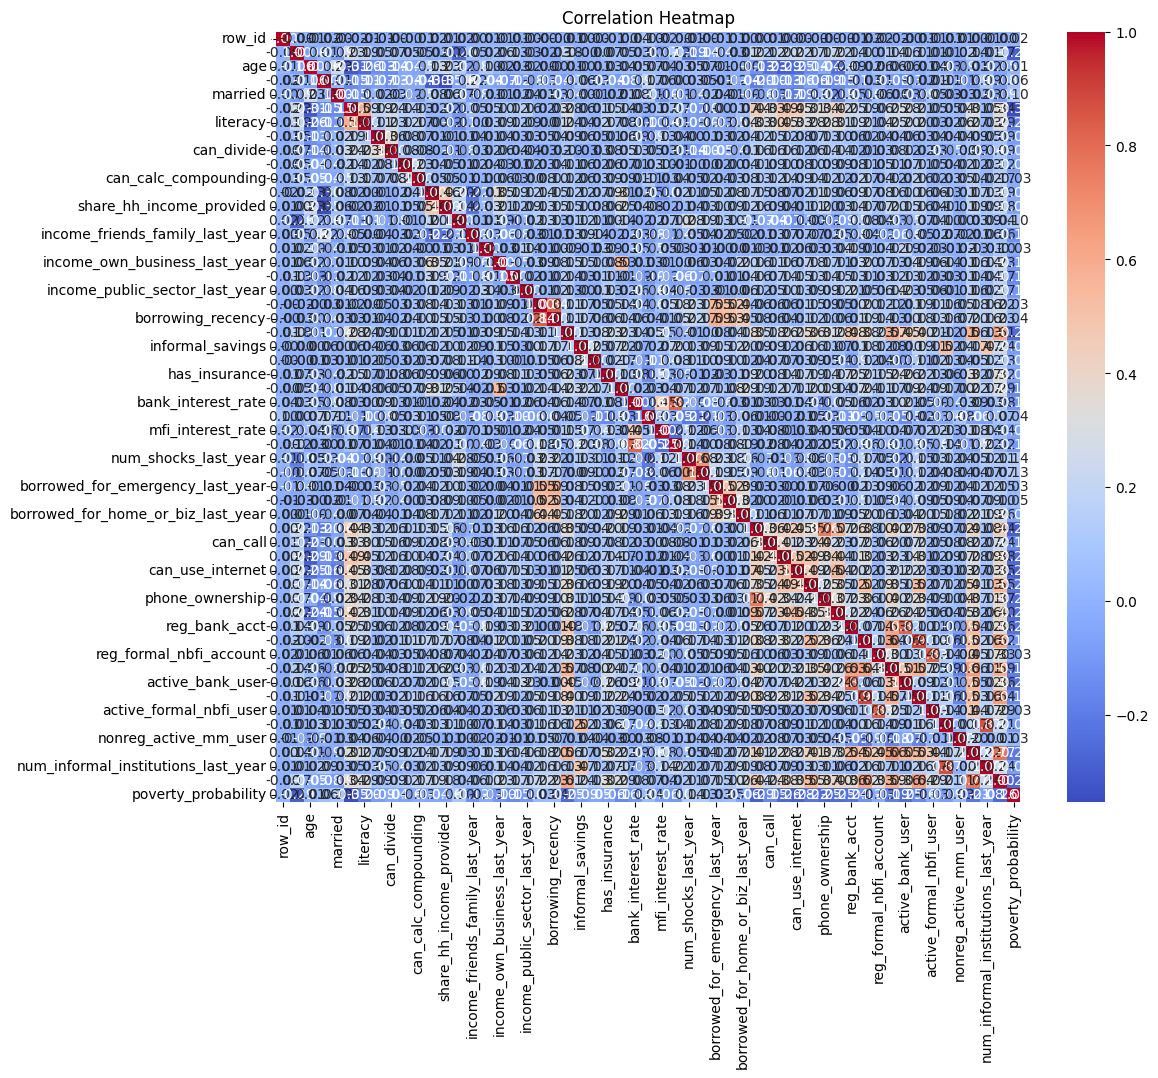

In [280]:
# Correlation heatmap to visualize the relationships between numeric features
plt.figure(figsize=(12, 10))
sns.heatmap(merged_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

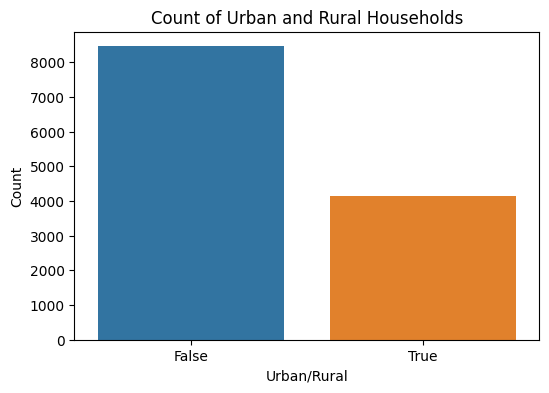

In [281]:
# Bar plot to visualize the count of urban and rural households in the poverty dataset
plt.figure(figsize=(6, 4))
sns.countplot(x='is_urban', data=merged_data)
plt.title("Count of Urban and Rural Households")
plt.xlabel("Urban/Rural")
plt.ylabel("Count")
plt.show()

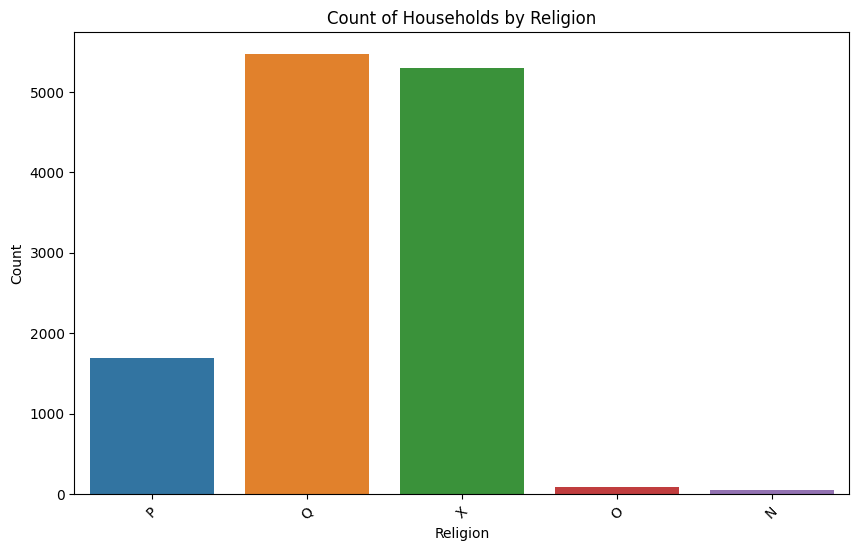

In [282]:
# Bar plot to visualize the count of households by religion in the poverty dataset
plt.figure(figsize=(10, 6))
sns.countplot(x='religion', data=merged_data)
plt.title("Count of Households by Religion")
plt.xlabel("Religion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

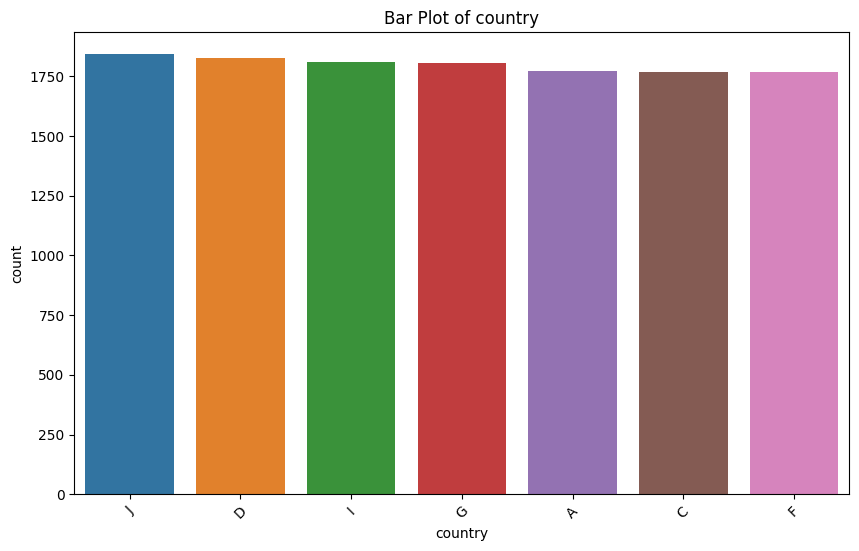

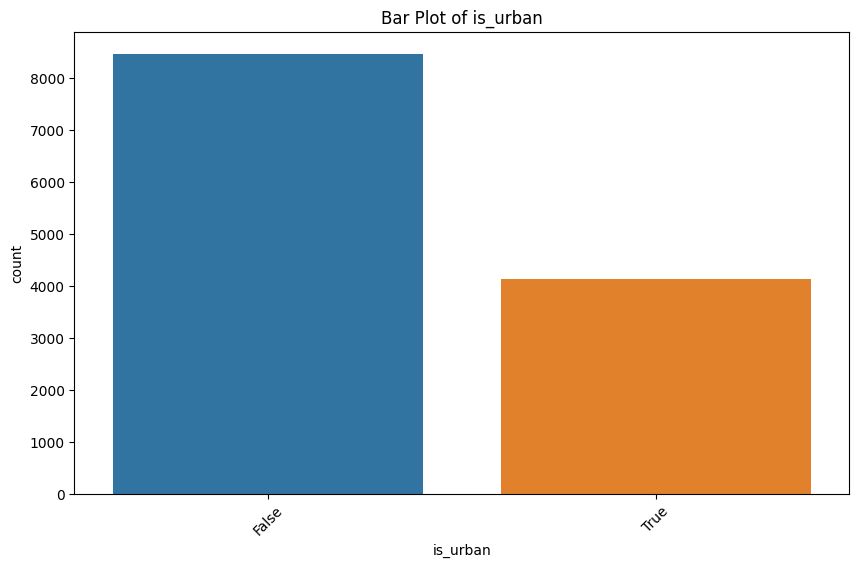

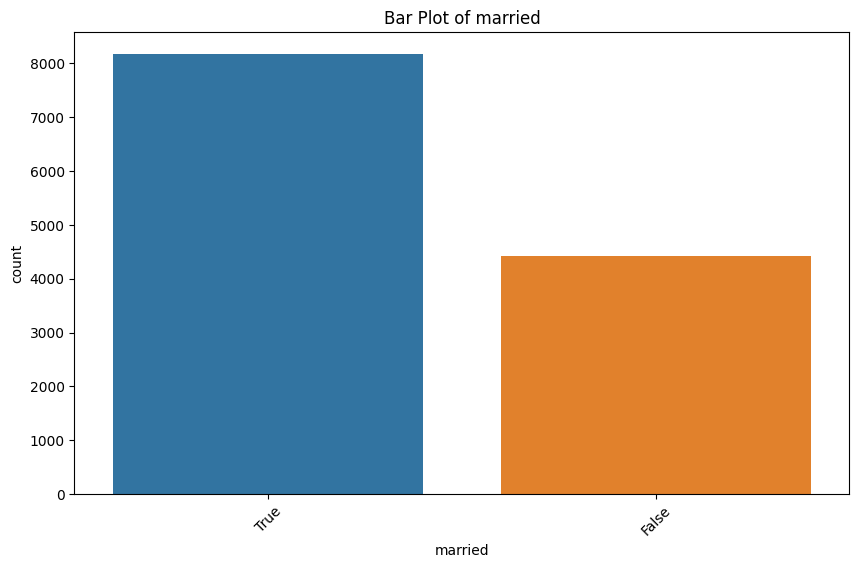

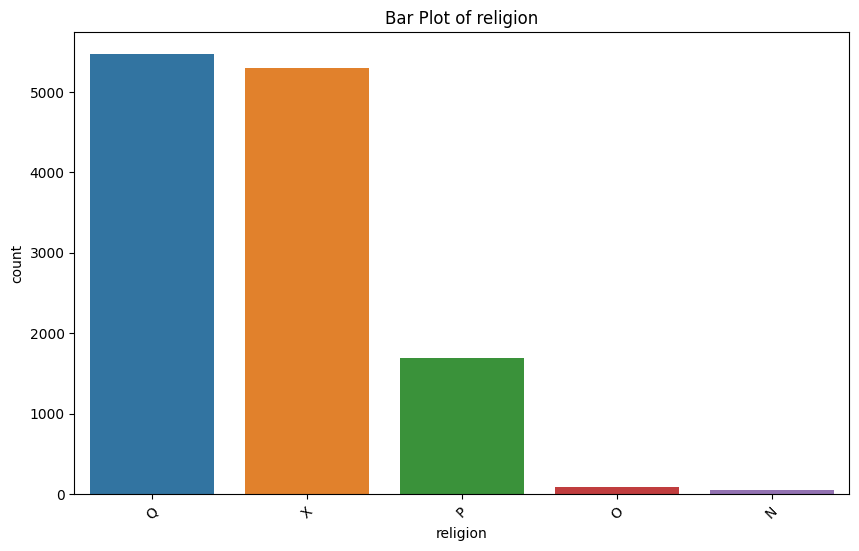

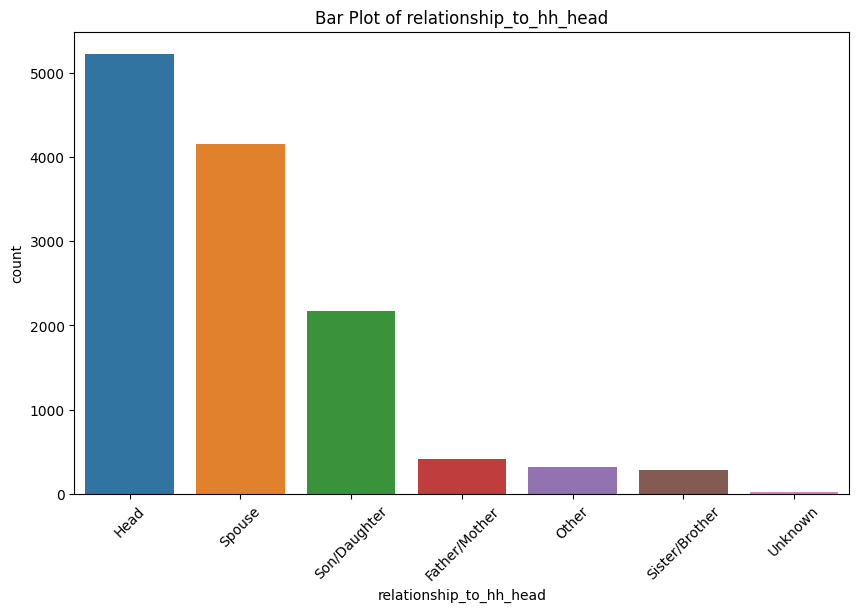

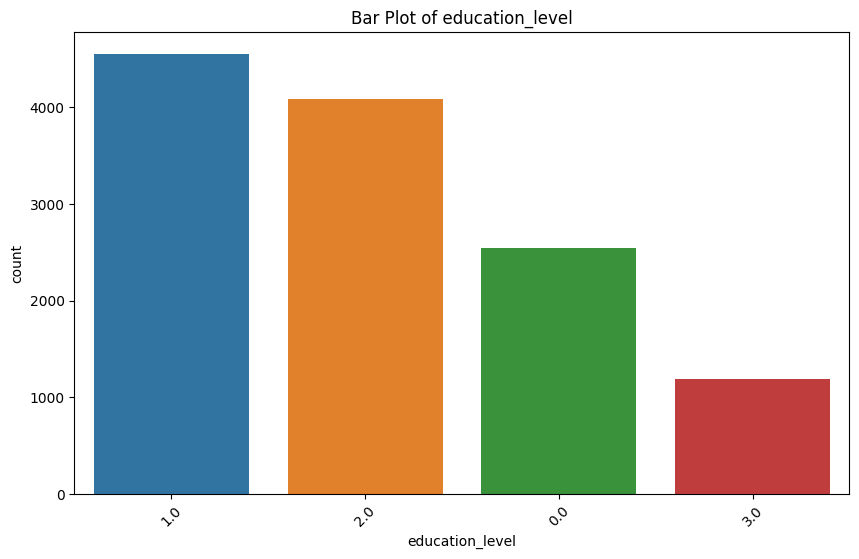

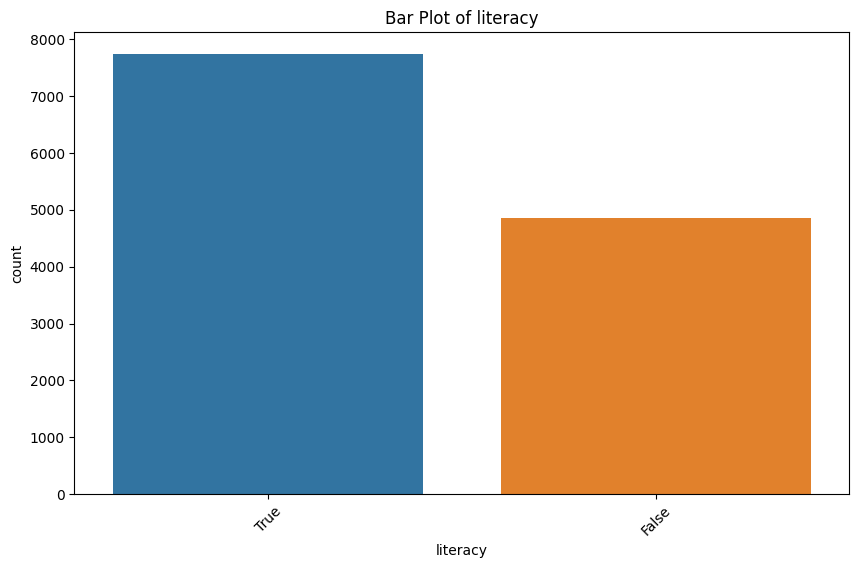

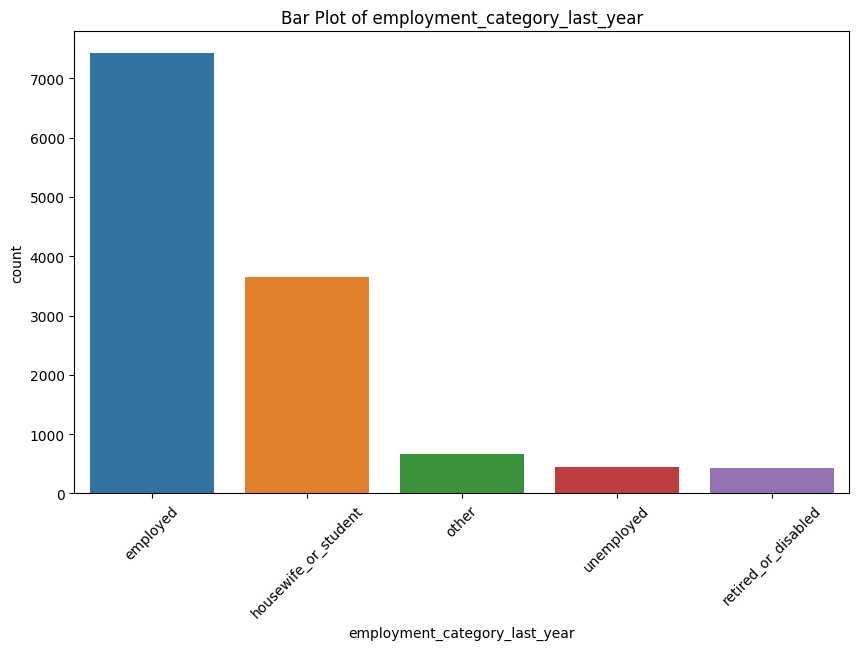

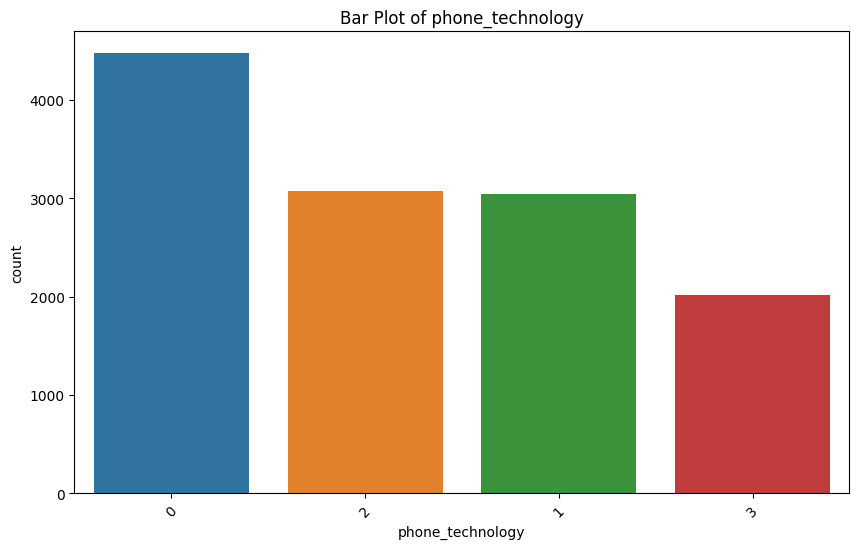

In [283]:
# Categorical feature bar plots
categorical_features = ['country', 'is_urban', 'married', 'religion', 'relationship_to_hh_head',
                        'education_level', 'literacy', 'employment_category_last_year', 'phone_technology']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=merged_data, x=feature, order=poverty_data[feature].value_counts().index)
    plt.title(f"Bar Plot of {feature}")
    plt.xticks(rotation=45)
    plt.show()

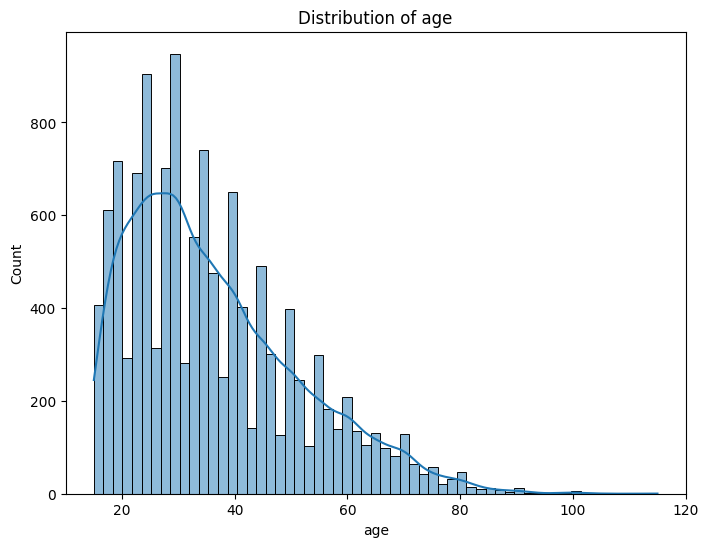

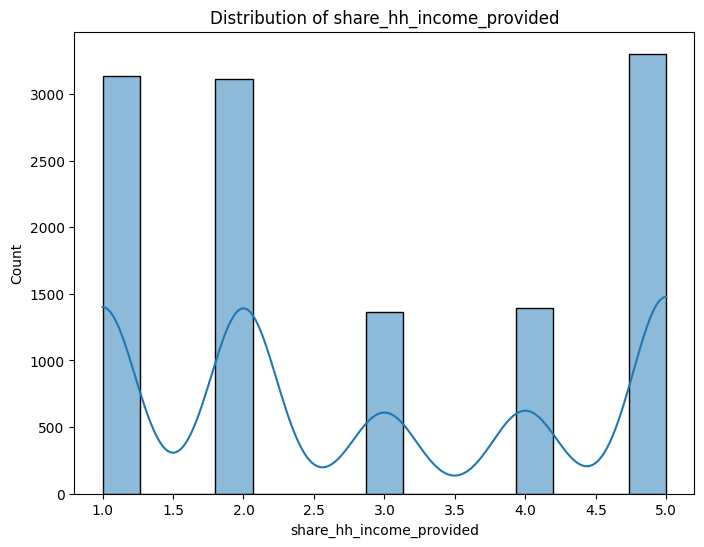

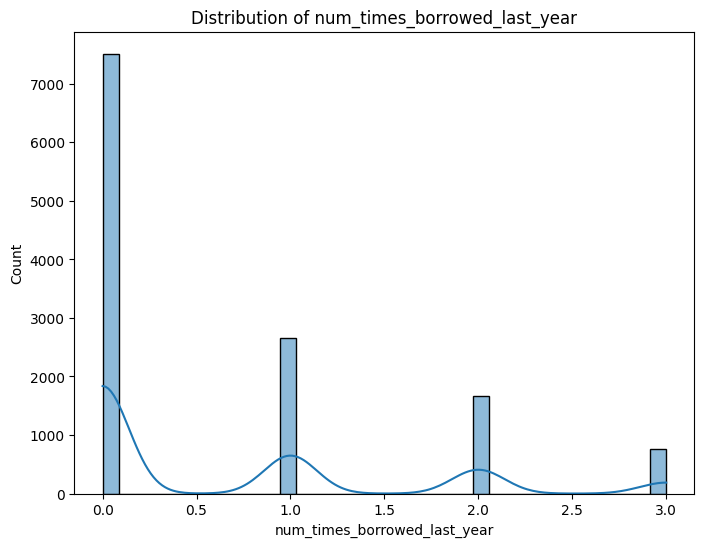

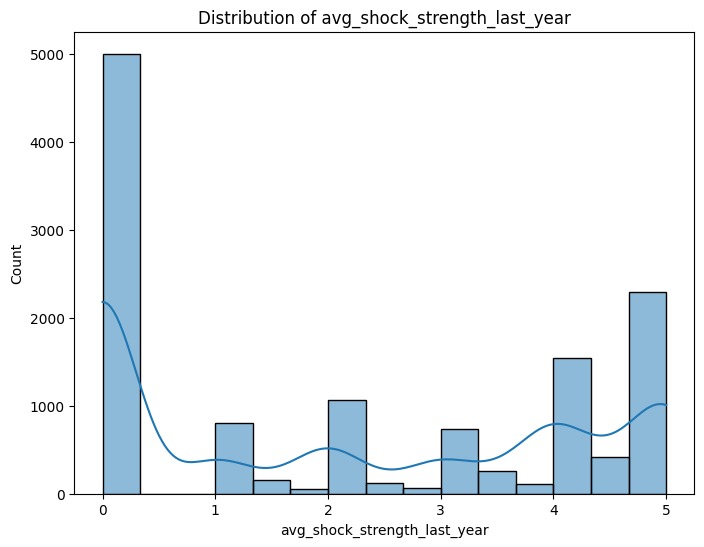

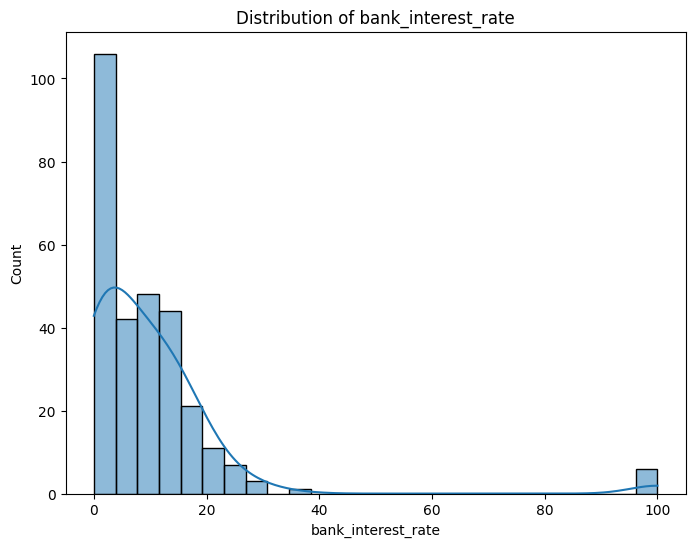

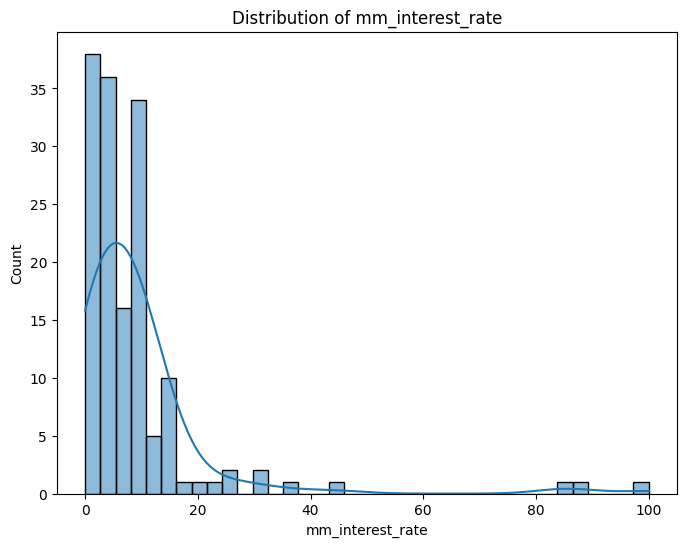

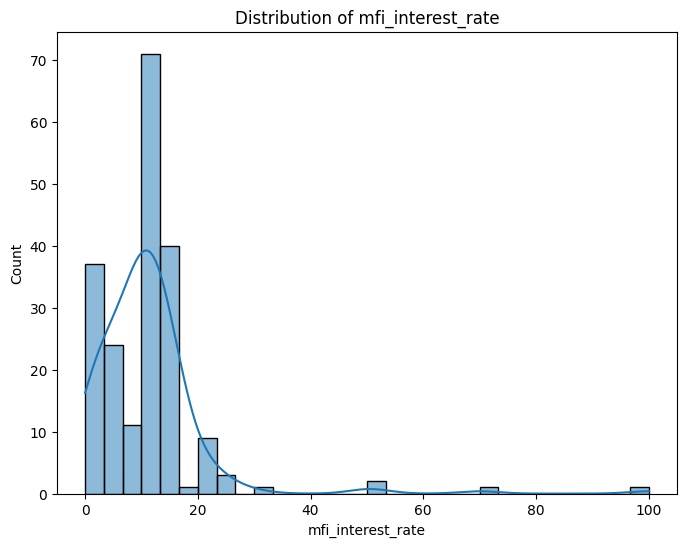

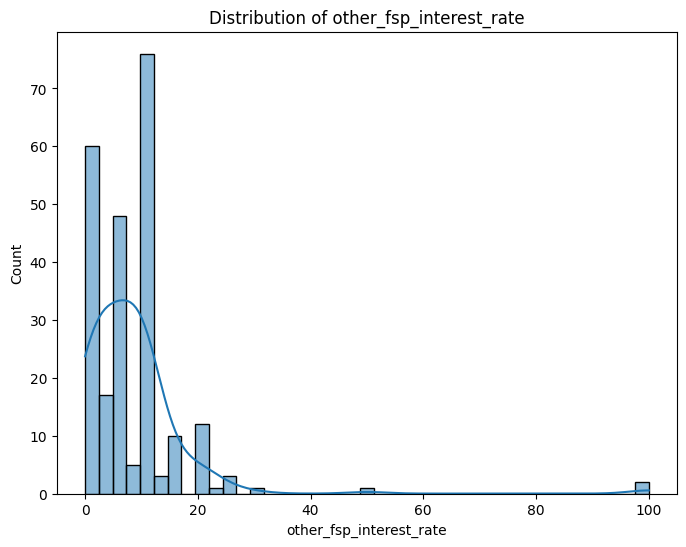

In [284]:
# Numeric feature distributions
numeric_features = ['age', 'share_hh_income_provided', 'num_times_borrowed_last_year', 'avg_shock_strength_last_year',
                    'bank_interest_rate', 'mm_interest_rate', 'mfi_interest_rate', 'other_fsp_interest_rate']

for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.histplot(data=merged_data, x=feature, kde=True)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.show()

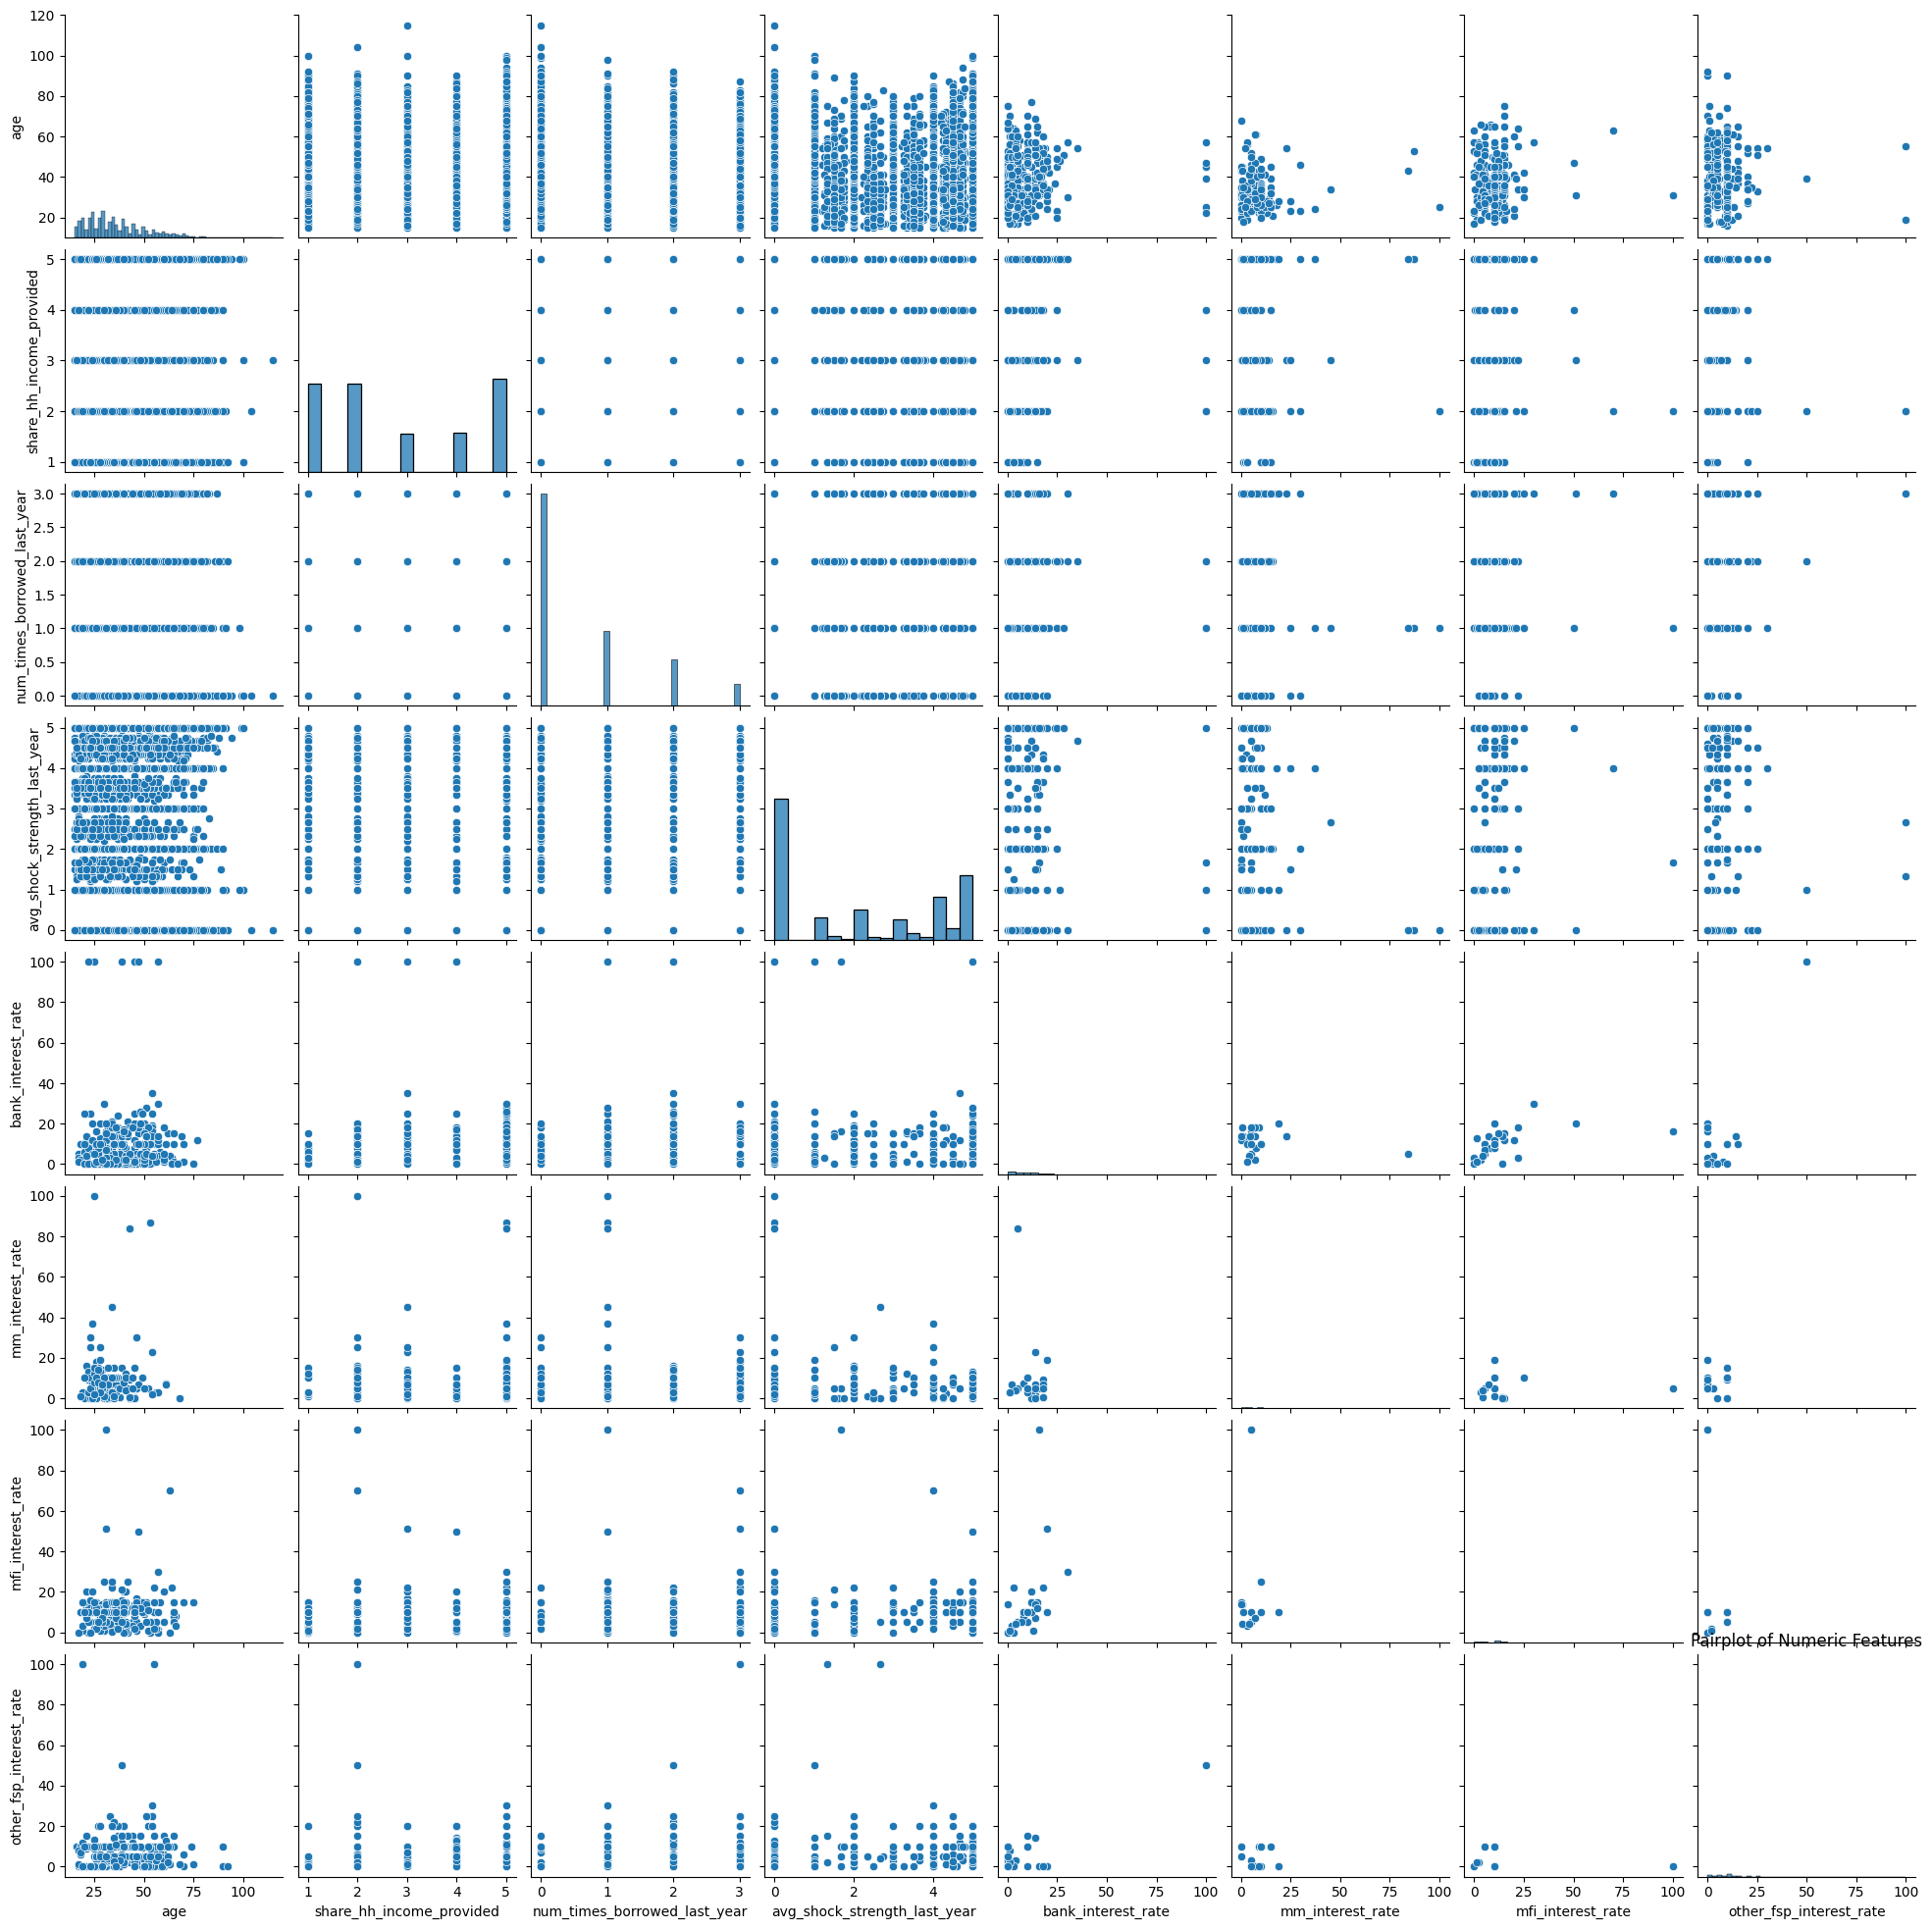

In [285]:
# Pairplot to visualize relationships between multiple numeric features
sns.pairplot(merged_data[numeric_features])
plt.title("Pairplot of Numeric Features")
plt.show()

In [286]:
# Interactive bar plot for poverty_probability by education_level using Plotly
fig = px.bar(merged_data, x='education_level', y='poverty_probability', color='is_urban', barmode='group',
             labels={'education_level': 'Education Level', 'poverty_probability': 'Poverty Probability'})
fig.update_layout(title='Poverty Probability by Education Level', xaxis_title='Education Level',
                  yaxis_title='Poverty Probability')
fig.show()

In [287]:
# Interactive scatter plot for age vs. poverty_probability using Plotly
fig = px.scatter(merged_data, x='age', y='poverty_probability', color='is_urban', hover_data=['country'],
                 labels={'age': 'Age', 'poverty_probability': 'Poverty Probability'})
fig.update_layout(title='Age vs. Poverty Probability', xaxis_title='Age', yaxis_title='Poverty Probability')
fig.show()

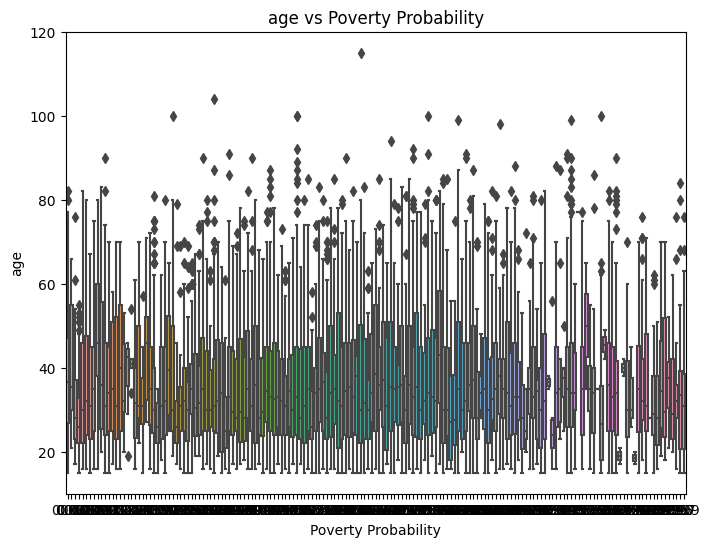

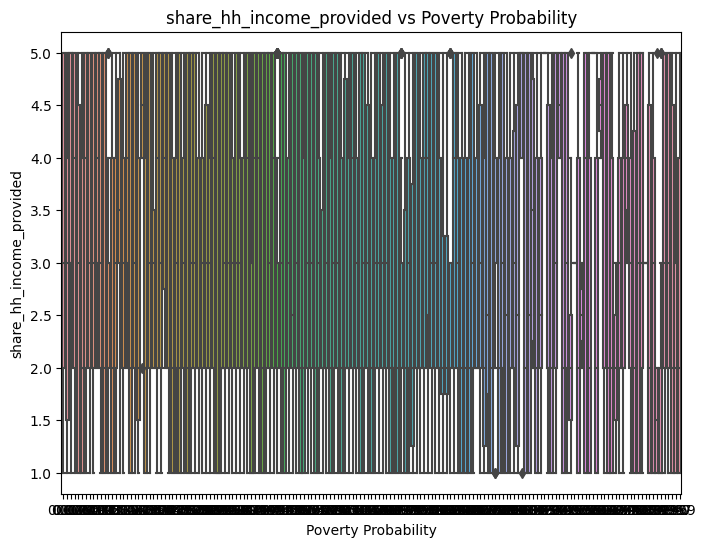

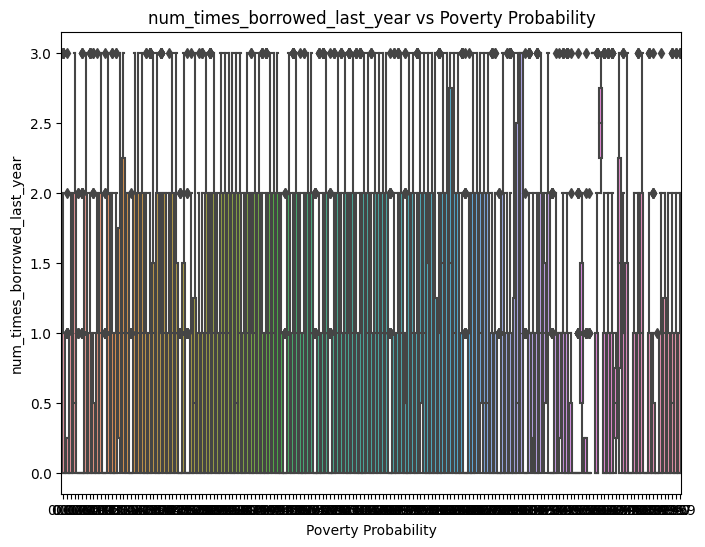

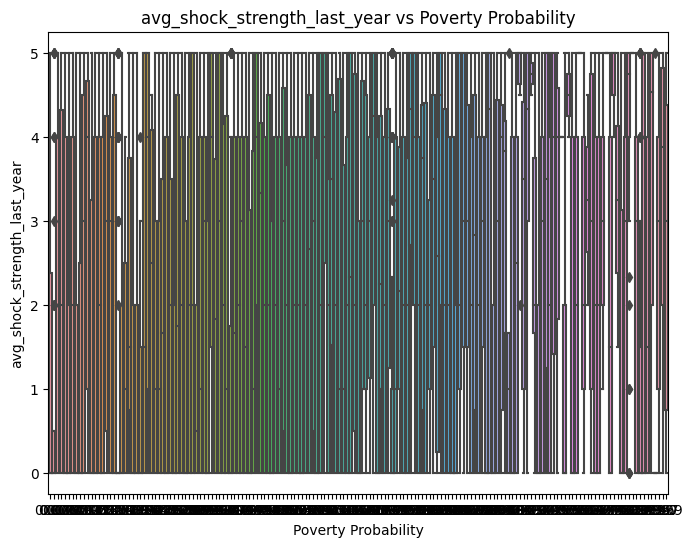

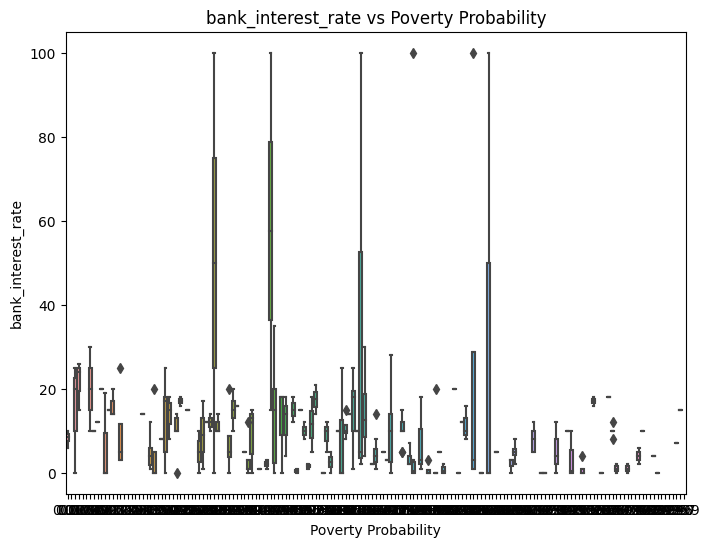

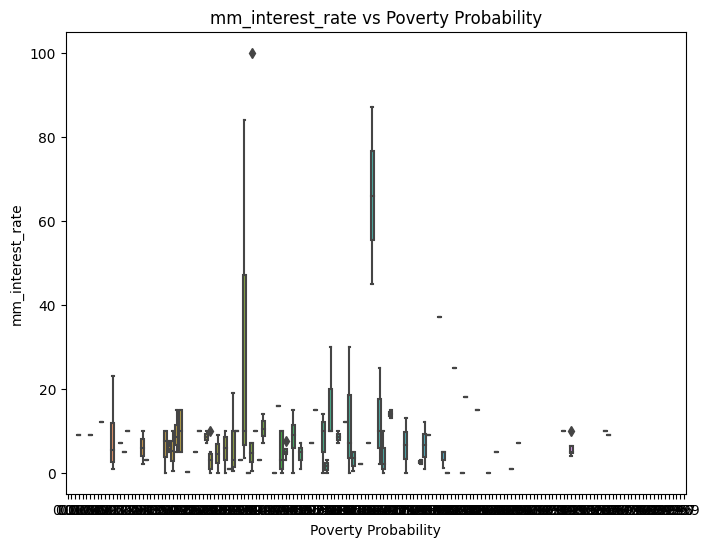

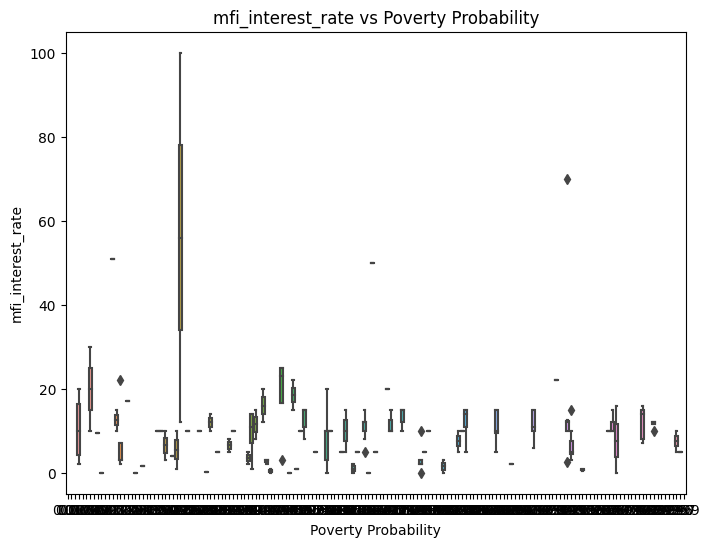

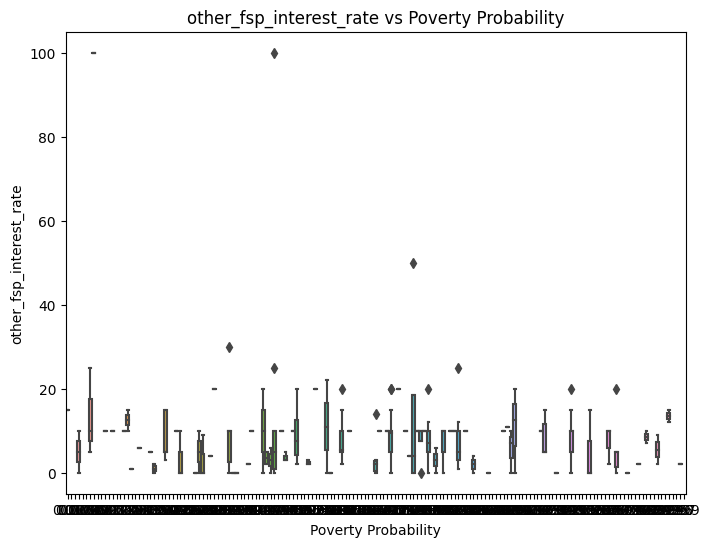

In [288]:
# Box plot for numeric features with respect to poverty_probability
for feature in numeric_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=merged_data, x='poverty_probability', y=feature)
    plt.title(f"{feature} vs Poverty Probability")
    plt.xlabel("Poverty Probability")
    plt.ylabel(feature)
    plt.show()

## Data Cleaning and Data Preprocessing

In [302]:
# Calculate the total number of missing values in each column
missing_values_count = merged_data.isnull().sum()

# Get the column names with missing values
columns_with_missing_values = missing_values_count[missing_values_count > 0].index

# Drop the columns with missing values from the DataFrame
merged_data_cleaned = merged_data.drop(columns=columns_with_missing_values)

In [303]:
merged_data_cleaned.shape

(12600, 54)

In [304]:
# Separate the target variable (poverty_probability) and features
X = merged_data_cleaned.drop(columns=['row_id', 'poverty_probability'])
y = merged_data_cleaned['poverty_probability']

# Split the data into train and test sets
# You can adjust the test_size and random_state parameters as needed
test_size = 0.2  # 20% of the data will be used for testing, change this as needed
random_state = 42  # Set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

In [305]:
train_columns_list = X_train.columns.tolist()
test_columns_list = X_test.columns.tolist()

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Loop through the specified columns and apply label encoding
for col in train_columns_list:
    X_train[col] = label_encoder.fit_transform(X_train[col])
for col in test_columns_list:
    X_test[col] = label_encoder.fit_transform(X_test[col])
    

In [306]:
# Use SelectKBest with f_regression score to select top 'k' features
k = 20  # Adjust this number as needed
selector = SelectKBest(score_func=f_regression, k=k)
X_train_new = selector.fit_transform(X_train, y_train)
X_test_new = selector.fit_transform(X_test, y_test)

In [307]:
print(X_train_new.shape)
print(y_train.shape)

(10080, 20)
(10080,)


In [308]:
print(X_test_new.shape)
print(y_test.shape)

(2520, 20)
(2520,)


## Model Training and Evaluation

## Linear Regression

In [309]:
lr = LinearRegression()
lr.fit(X_train_new, y_train)

LinearRegression()

In [310]:
predictions = lr.predict(X_test_new)

In [311]:
predictions.shape

(2520,)

In [312]:
threshold = 0.5
binary_predictions = predictions >= threshold
accuracy = np.mean(binary_predictions == (y_test >= threshold)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse:.2f}")

Accuracy: 72.18%
RMSE: 0.27


In [313]:
# Define a threshold to convert probabilities to class labels (binary classification)
threshold = 0.5
binary_predictions = (predictions >= threshold).astype(int)
binary_true_labels = (y_test >= threshold).astype(int)

# Assuming you have the true labels for the test data
# true_labels = ...

# Generate the classification report
class_report = classification_report(binary_true_labels, binary_predictions)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       846
           1       0.77      0.83      0.80      1674

    accuracy                           0.72      2520
   macro avg       0.69      0.67      0.67      2520
weighted avg       0.71      0.72      0.72      2520



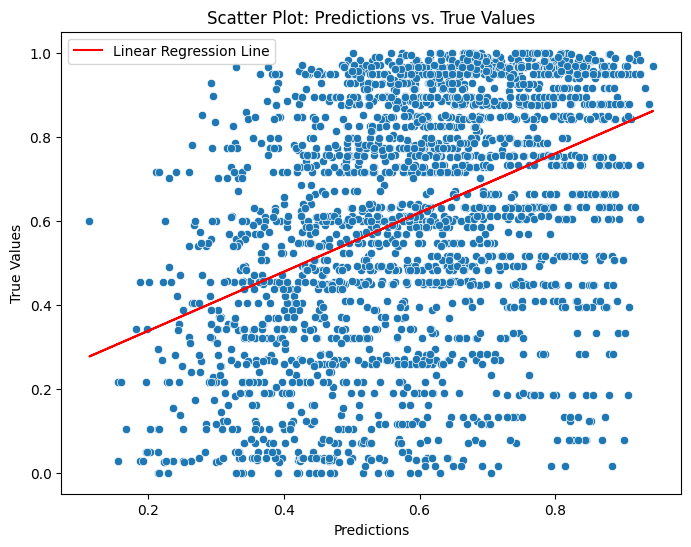

In [314]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=predictions, y=y_test)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Scatter Plot: Predictions vs. True Values')

# Fit a linear regression line
regression_model = LinearRegression()
regression_model.fit(predictions.reshape(-1, 1), y_test)
plt.plot(predictions, regression_model.predict(predictions.reshape(-1, 1)), color='red', label='Linear Regression Line')

plt.legend()
plt.show()

In [315]:
joblib.dump(lr, 'LinearRegression.pkl')

['LinearRegression.pkl']

## K-Nearest Neighbour

In [316]:
knn = KNeighborsRegressor(n_neighbors=4)
knn.fit(X_train_new, y_train)

KNeighborsRegressor(n_neighbors=4)

In [317]:
y_pred = knn.predict(X_test_new)

In [318]:
threshold = 0.5
binary_predictions = (y_pred >= threshold).astype(int)
binary_true_labels = (y_test >= threshold).astype(int)
accuracy = np.mean(binary_predictions == (y_test >= threshold)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")

Accuracy: 68.13%
RMSE: 0.29


In [319]:
class_report = classification_report(binary_true_labels, binary_predictions)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.50      0.51       846
           1       0.75      0.77      0.76      1674

    accuracy                           0.68      2520
   macro avg       0.64      0.64      0.64      2520
weighted avg       0.68      0.68      0.68      2520



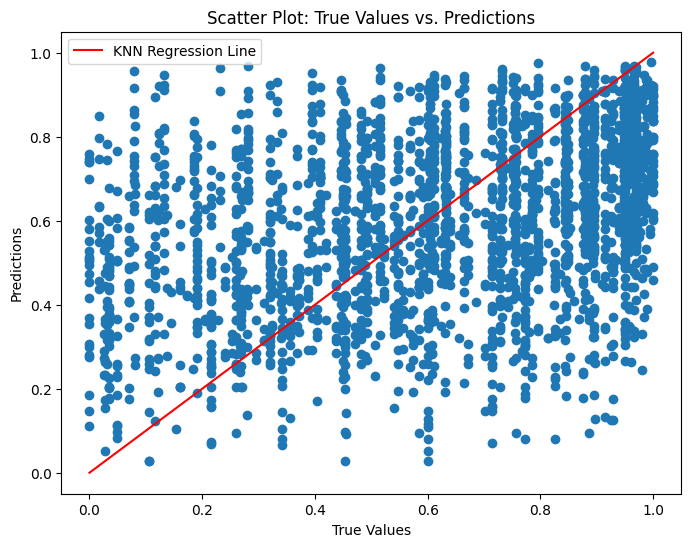

In [320]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot: True Values vs. Predictions')

# Plot the KNN regression line
min_value = min(np.min(y_test), np.min(predictions))
max_value = max(np.max(y_test), np.max(predictions))
plt.plot([min_value, max_value], [min_value, max_value], color='red', label='KNN Regression Line')

plt.legend()
plt.show()

In [321]:
joblib.dump(knn, 'KNNRegression.pkl')

['KNNRegression.pkl']

## Random Forest

In [322]:
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the Random Forest Regressor using the training data
rf_regressor.fit(X_train_new, y_train)

RandomForestRegressor(random_state=42)

In [323]:
y_predict = rf_regressor.predict(X_test_new)

In [324]:
threshold = 0.5
binary_predictions = (y_predict >= threshold).astype(int)
binary_true_labels = (y_test >= threshold).astype(int)
accuracy = np.mean(binary_predictions == (y_test >= threshold)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_predict))
print(f"RMSE: {rmse:.2f}")

Accuracy: 70.83%
RMSE: 0.26


In [325]:
class_report = classification_report(binary_true_labels, binary_predictions)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.56       846
           1       0.77      0.79      0.78      1674

    accuracy                           0.71      2520
   macro avg       0.67      0.67      0.67      2520
weighted avg       0.71      0.71      0.71      2520



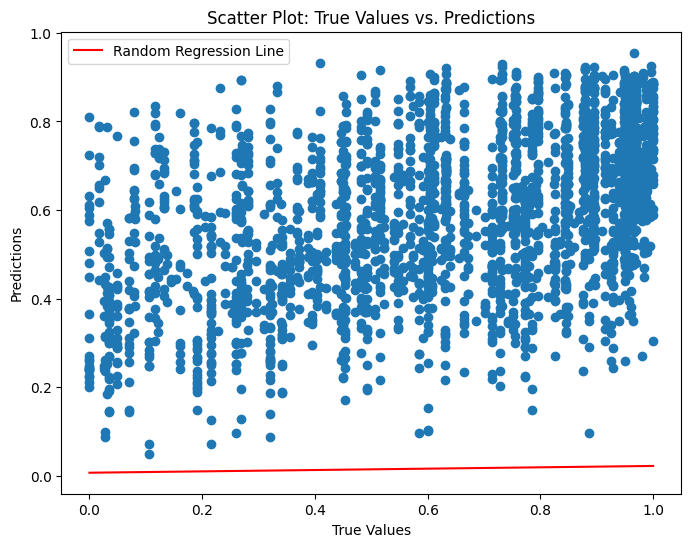

In [326]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot: True Values vs. Predictions')

# Plot a random regression line (just for visualization)
min_value = min(np.min(y_test), np.min(predictions))
max_value = max(np.max(y_test), np.max(predictions))
random_slope = np.random.rand()  # Random slope between 0 and 1
random_intercept = np.random.rand()  # Random intercept between 0 and 1
plt.plot([min_value, max_value], [min_value * random_slope + random_intercept, max_value * random_slope + random_intercept], color='red', label='Random Regression Line')

plt.legend()
plt.show()

In [327]:
joblib.dump(rf_regressor, 'RandomForest.pkl')

['RandomForest.pkl']

## Support Vector Machine (SVM)

In [328]:
svm_regressor = SVR(kernel='rbf')

# Train the SVR model using the training data
svm_regressor.fit(X_train_new, y_train)

SVR()

In [329]:
y_pr = svm_regressor.predict(X_test_new)

In [330]:
threshold = 0.5
binary_predictions = (y_pr >= threshold).astype(int)
binary_true_labels = (y_test >= threshold).astype(int)
accuracy = np.mean(binary_predictions == (y_test >= threshold)) * 100
print(f"Accuracy: {accuracy:.2f}%")

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pr))
print(f"RMSE: {rmse:.2f}")

Accuracy: 69.96%
RMSE: 0.28


In [331]:
class_report = classification_report(binary_true_labels, binary_predictions)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.53      0.54       846
           1       0.77      0.79      0.78      1674

    accuracy                           0.70      2520
   macro avg       0.66      0.66      0.66      2520
weighted avg       0.70      0.70      0.70      2520



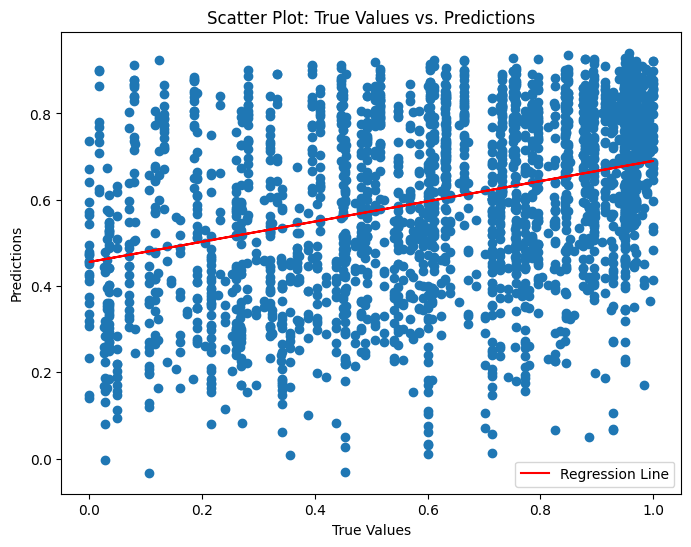

In [332]:
# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pr)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Scatter Plot: True Values vs. Predictions')

# Fit a linear regression line to the scatter plot
regression_model = LinearRegression()
regression_model.fit(y_test.values.reshape(-1, 1), predictions)
plt.plot(y_test, regression_model.predict(y_test.values.reshape(-1, 1)), color='red', label='Regression Line')

plt.legend()
plt.show()

In [333]:
joblib.dump(svm_regressor, 'SVM.pkl')

['SVM.pkl']